In [5]:
import numpy as np
import wavio
import time
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

In [57]:
def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]


def stretch_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_stretch == 0 else 0
                     for i in range(len(signal_in) * N_stretch)])


def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)


def filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den):
    '''Función que permite realizar el proceso de filtrado y de corrección por
    delay de grupo a una señal a filtrar.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal a filtrar y corregir.
    gd : int or float
        Delay de grupo de la señal.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    num : int, float, list or ndarray
        Coeficientes del numerador para el filtro.
    den : int, float, list or ndarray
        Coeficientes del denominador para el filtro.
    
    Returns
    -------
    signal_to_filt : ndarray
        Señal que se utiliza para filtrar considerando el gd_padding.
    signal_filtered : ndarray
        Señal filtrada y corregida por el delay de grupo.
    '''
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in

    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')

    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_to_filt)

    # Si se hace padding, se debe cortar de tal forma que se logre sincro-
    # nizar la señal de entrada en función del delay de grupo
    if gd_padding is not None:
        delay = gd
        
        # Definición de los índices a considerar. Se escogen estos índices
        # ya que se asume que el comportamiento ideal de la señal 3 veces
        # paddeada, se encuentra en el centro del arreglo
        ini_index = int(len(signal_in) + delay)
        end_index = int(2 * len(signal_in) + delay)

        # Recortando
        signal_filtered = signal_filtered[ini_index:end_index]

    return signal_to_filt, signal_filtered

    
def lowpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa bajos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    altas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in
    
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp


def highpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa altos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    bajas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in

    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((([0] * cutpoint), 
                                 mag[cutpoint:-cutpoint],
                                ([0] * cutpoint)))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_hp = np.real(np.fft.ifft(signal_cutted))

    return signal_hp


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=80, use_exact=True, print_window=True,
                       fir_type='lowpass', method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parameters
    ----------
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    samplerate: int 
        Tasa de muestreo de la señal utilizada.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    use_exact : bool, optional
        Booleano que indica si se usa el valor exacto de transición entre bandas 
        (delta omega). Por defecto es True
    print_window : bool, optional.
        Si se imprime la ventana seleccionada y su orden. Por defecto es False.
    fir_type : {'lowpass', 'highpass'}, optional
        Filtro FIR a crear, que puede ser pasa bajo o pasa alto. Por defecto es 'lowpass'.
    method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    parity : {'odd', 'even'}, optional
        Cantidad par o impar de puntos para el filtro. Por defecto es 'odd'.
    apply_firwin : bool, optional
        Si se aplica la función firwin o si se hace manualmente. Por defecto es False.
    
    Returns
    -------
    h_n : ndarray
        Ventana del filtro deseado.
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))
    
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # OJO: La opción paridad tiene directa relación con el largo de la 
    # salida L, no con M. Por ende, para 'odd', se hará M par para que
    # L sea impar (y viceversa, ya que L = M + 1).
    if parity == 'odd':
        # Si es que M es par, mantenerlo par, si es que es impar, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 == 0 else M + 1
    
    elif parity == 'even':
        # Si es que M es impar, mantenerlo impar, si es que es par, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 != 0 else M + 1
    
    else:
        raise Exception('Opción de paridad no válida.')
    
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             pass_zero=fir_type,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window


def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. 'cut' es un método no convencional en el que
        se todas las frecuencias filtradas de la magnitud se hacen 0. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        _, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                      freq_stop, method=lp_method, 
                                      fir_method=fir_method, gpass=gpass, 
                                      gstop=gstop, plot_filter=plot_filter,
                                      correct_by_gd=correct_by_gd,
                                      gd_padding=gd_padding,
                                      normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, method='lowpass',
                      trans_width=50, lp_method='fir',
                      resample_method='interp1d',
                      fir_method='kaiser', gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1]
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_out = lowpass_filter(signal_stretched, new_samplerate, 
                                           freq_pass, freq_stop, method=lp_method, 
                                           fir_method=fir_method, gpass=gpass, 
                                           gstop=gstop, correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           plot_filter=plot_filter, 
                                           normalize=normalize)    
        elif method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_out = lowpass_cut_frequency(signal_stretched, samplerate, 
                                               freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / new_samplerate * samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_out)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out
    
    
def resampling_by_points(signal_in, samplerate, N_desired, trans_width=50,
                         resample_method='interp1d', lp_method='fir', fir_method='kaiser', 
                         gpass=1, gstop=80, correct_by_gd=True, gd_padding='periodic',
                         plot_filter=False, normalize=True):
    '''Función que resamplea una señal de entrada en función de la cantidad de puntos
    deseados de salida.
    
    Parameters
    ----------
    signal_in : list, tuple or ndarray
        Señal de entrada a resamplear.
    N_desired : int
        Cantidad de puntos deseada en la señal de salida.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones.
    resample_method : {'resample', 'resample poly', 'interp1d'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    signal_out : ndarray
        Señal resampleada con la cantidad de puntos solicitados en "N_desired".
    '''
    # En caso de que sea igual, se mantiene
    if N_desired == len(signal_in):
        # Solo se normaliza en caso de ser pertinente
        if normalize:
            return signal_in / max(abs(signal_in))
        else:    
            return signal_in
    
    # En caso de que sea menor, se aplica "downsampling" (resampleo)
    elif N_desired < len(signal_in):
        # Definición de la frecuencia de corte para aplicación en la función
        freq_stop = N_desired * samplerate / (2 * len(signal_in))
        # Definición de la frecuencia final de pasabanda
        freq_pass = freq_stop - trans_width
        
        # Aplicando el filtro pasa bajos (anti aliasing)
        _, signal_to_res = lowpass_filter(signal_in, samplerate, freq_pass, 
                                          freq_stop, method=lp_method, 
                                          fir_method=fir_method, 
                                          gpass=gpass, gstop=gstop, 
                                          plot_filter=plot_filter,
                                          correct_by_gd=correct_by_gd,
                                          gd_padding=gd_padding,
                                          normalize=normalize)
    
    # En caso de que sea mayor, se mantiene la señal normal
    elif N_desired > len(signal_in):
        # Solo se normaliza en caso de ser pertinente
        if normalize:
            signal_to_res = signal_in / max(abs(signal_in))
        else:    
            signal_to_res = signal_in
    
    # Y resampleando esta señal
    if resample_method == 'resample':
        # Señal de salida
        signal_out = signal.resample(signal_to_res, N_desired)

    elif resample_method == 'resample_poly':
        # Señal de salida
        signal_out = signal.resample_poly(signal_to_res, up=N_desired, 
                                          down=len(signal_in))

    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_to_res))

        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_desired)

        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_to_res)

        # Señal de salida
        signal_out = f(x_new)

    else:
        raise Exception('Opción no válida para el método. Por favor, '
                        'intente nuevamente con una opción válida.')
    
    return signal_out


def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
        
        
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
        
    elif method == 'cut':
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False
        
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya solo hay corte, no desfase)
        gd = 0
        
        # Definición de salida num y den
        num = den = None
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('Señal a filtrar')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered

    
def highpass_by_complement_lowpass_filter(signal_in, samplerate, freq_stop, freq_pass,
                                          lp_process='manual_time_design', 
                                          fir_method='kaiser', gpass=1, gstop=80, 
                                          plot_filter=False, correct_by_gd=True, 
                                          gd_padding='periodic', normalize=True):
    '''Rutina que realiza un proceso de filtrado pasa altos a partir de un filtro pasa 
    bajos.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
        
    Returns
    -------
    info : tuple
        Contiene delay de grupo, numerador y denominador del polinomio que describe el filtro
    signal_filtered : ndarray
        Señal filtrada.
        
    Referencias
    -----------
    [1] https://dsp.stackexchange.com/questions/20171/
        how-to-produce-a-high-pass-filter-from-a-low-pass-one
    '''
    # Se obtiene el filtro pasa bajo
    info, signal_lp = lowpass_filter(signal_in, samplerate, 
                                     freq_pass=freq_stop, freq_stop=freq_pass,
                                     method='fir', fir_method=fir_method, 
                                     gpass=gpass, gstop=gstop, plot_filter=False,
                                     correct_by_gd=correct_by_gd, gd_padding=gd_padding,
                                     normalize=True)

    if lp_process == 'manual_freq_design':
        # Obteniendo la información del filtro
        num, den = info[1:]

        # Aplicando [1]
        h_high = np.real(np.fft.ifft(1 - abs(np.fft.fft(num))))

    elif lp_process == 'manual_time_design':
        # Obteniendo la información del filtro
        num, den = info[1:]

        # Es necesario ordenarlo temporalmente, para ello se ordena de tal forma que
        # la muestra 0 sea el origen
        N = len(num)
        num_reordered = np.concatenate((num[N//2:], num[:N//2]))

        # Se define el impulso
        impulse = np.array([1] + [0] * (N - 1))

        # Aplicando [1]
        h_high = np.real(impulse - num_reordered)

    elif lp_process == 'freqz_design':
        # Obteniendo la información del filtro
        num, den = info[1:]

        # Se obtiene la respuesta en frecuencia de la señal
        w, h_freq = signal.freqz(b=num, a=den, whole=True)

        # Aplicando [1]
        h_high = np.real(np.fft.ifft(1 - abs(h_freq)))

    elif lp_process == 'signal_substraction':
        # Una versión muy poco refinada sería esta
        if correct_by_gd:
            # Dado que ya tenemos la señal filtrada mediante pasa bajos, el resultado será
            # simplemente la resta de la señal original menos la señal cortada en pasa bajo
            to_return = signal_in - signal_lp
            
            if normalize:
                return info, to_return / max(abs(to_return))
            else:
                return info, to_return
        else:
            raise Exception('Este tipo de filtro solo se puede hacer con un filtro FIR '
                            'para la etapa del pasabajo con corrección de GD.')
    
    # Dado que el filtro necesita ser simétrico con respecto a su punto central, se reordena
    # de tal forma que quede como "forma sinc" de pasa altos
    N = len(num)
    h_high = np.concatenate((h_high[N//2+1:], h_high[:N//2+1]))
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered = \
            filt_and_correct_group_delay(signal_in, info[0], gd_padding, h_high, 1)
    else:
        # Definición de la señal a filtrar
        signal_to_filt = signal_in
        print('paso')
        # Filtrando
        signal_filtered = signal.lfilter(h_high, 1, signal_to_filt)
        
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('Señal a filtrar')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return info, signal_filtered / max(abs(signal_filtered))
    else:
        return info, signal_filtered
        
    
def highpass_filter(signal_in, samplerate, freq_stop, freq_pass,
                    method='fir', lp_process='manual_time_design',
                    fir_method='kaiser', gpass=1, gstop=80, 
                    plot_filter=False, correct_by_gd=True,
                    gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasa altos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    info : tuple
        Contiene delay de grupo, numerador y denominador del polinomio que describe el filtro
    signal_filtered : ndarray
        Señal filtrada.
    
    Referencias
    -----------
    [1] https://dsp.stackexchange.com/questions/20171/
        how-to-produce-a-high-pass-filter-from-a-low-pass-one
    '''
    
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 fir_type='highpass', print_window=plot_filter,
                                 apply_firwin=True)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
            
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
    
    elif method == 'cut':
        # Filtrando la señal
        signal_filtered =  highpass_cut_frequency(signal_in, samplerate, 
                                                  freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False

        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None

        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False

        # Definición gd (ya solo hay corte, no desfase)
        gd = 0

        # Definición de salida num y den
        num = den = None
        
    elif method == 'lowpass_complement':
        return highpass_by_complement_lowpass_filter(signal_in, samplerate, 
                                                     freq_stop, freq_pass,
                                                     lp_process=lp_process, 
                                                     fir_method=fir_method, 
                                                     gpass=gpass, gstop=gstop, 
                                                     plot_filter=plot_filter, 
                                                     correct_by_gd=correct_by_gd, 
                                                     gd_padding=gd_padding, 
                                                     normalize=normalize)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' una opción disponible válido.')
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den, worN=2048)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered
    
    
def bandpass_filter(signal_in, samplerate, freq_stop_1, freq_pass_1, 
                    freq_pass_2, freq_stop_2, bp_method='sequence', 
                    lp_method='fir', hp_method='fir', 
                    lp_process='manual_time_design',
                    fir_method='kaiser', gpass=1, gstop=80, 
                    plot_filter=False, correct_by_gd=True, 
                    gd_padding='periodic', normalize=False):
    '''Función que permite crear un filtro pasa banda con frecuencias
    de corte ingresadas por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop_1 : float
        Frecuencia de corte de la rechaza banda por la izquierda.
    freq_pass_1 : float
        Frecuencia de corte de la pasa banda por la izquierda.
    freq_pass_2 : float
        Frecuencia de corte de la pasa banda por la derecha.
    freq_stop_2 : float
        Frecuencia de corte de la rechaza banda por la derecha.
    bp_method : {'sequence', 'scipy_fir', 'scipy_iir'}, optional
        Método de construcción del filtro pasa banda. Para 'sequence' se concatena un
        filtro pasa bajos seguido de un pasa altos (es la única opción que soporta
        corrección por GD). Para 'scipy_fir' y 'scipy_iir' se hace uso de las funciones
        'firwin' y 'iirdesign' para el diseño del filtro (ajustado a los parámetros
        solicitados). Por defecto es 'sequence'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    signal_filtered : ndarray
        Señal filtrada.
    '''
    # Normalizando la señal de entrada (en caso de no estar normalizada)
    signal_norm = signal_in / max(abs(signal_in))
    
    if bp_method == 'sequence':
        # En primer lugar se aplica un filtro pasabajo (frecuencias más altas)
        info_lp, signal_lp = lowpass_filter(signal_norm, samplerate, 
                                            freq_pass=freq_pass_2, 
                                            freq_stop=freq_stop_2,
                                            method=lp_method, 
                                            fir_method=fir_method, 
                                            gpass=gpass, gstop=gstop, 
                                            plot_filter=False, 
                                            correct_by_gd=correct_by_gd, 
                                            gd_padding=gd_padding, 
                                            normalize=False)
        
        # Luego se aplica un filtro pasa altos (frecuencias más bajas)
        info_hp, signal_bp = highpass_filter(signal_lp, samplerate, 
                                             freq_stop=freq_stop_1, 
                                             freq_pass=freq_pass_1,
                                             method=hp_method,
                                             lp_process=lp_process,
                                             fir_method=fir_method, 
                                             gpass=gpass, gstop=gstop, 
                                             plot_filter=False, 
                                             correct_by_gd=correct_by_gd, 
                                             gd_padding=gd_padding, 
                                             normalize=normalize)
        
    else:
        if bp_method == 'scipy_fir':
            # Obteniendo los filtros correspondientes
            lp_wind = fir_filter_adapted(freq_pass=freq_pass_2, 
                                         freq_stop=freq_stop_2, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='lowpass', method='kaiser', parity='odd', 
                                         apply_firwin=False)
            
            hp_wind = fir_filter_adapted(freq_pass=freq_stop_1, 
                                         freq_stop=freq_pass_1, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='highpass', method='kaiser', parity='odd', 
                                         apply_firwin=True)
            
            # Definición del largo de la ventana (se escoge el máximo para que cumpla ambas
            # condiciones ya que en caso de elegir la menor no se cumpliría la otra)
            N = max(len(lp_wind), len(hp_wind))
            
            # Definición de la banda de transición
            width = min(abs(freq_pass_1 - freq_stop_1), abs(freq_pass_2 - freq_stop_2))
            
            # Aplicando firwin
            h = signal.firwin(N, [1/2 * (freq_pass_1 + freq_stop_1), 1/2 * (freq_pass_2 + freq_stop_2)],
                              width=width, window='blackman', pass_zero='bandpass', fs=samplerate)
            
            # Definiendo entonces numerador y denominador
            num = h
            den = 1
            
            # Definición gd
            _, gd_list = signal.group_delay((num, den))
            
            # Definición de gd
            gd = round(np.mean(gd_list))
            
        elif bp_method == 'scipy_iir':
            # Diseñando el filtro pasa banda
            num, den = signal.iirdesign(wp=[freq_pass_1, freq_pass_2],
                                        ws=[freq_stop_1, freq_stop_2],
                                        gpass=gpass, gstop=gstop,
                                        fs=samplerate)
            
            # Definiendo de manera automática correct_by_gd en False (solo para FIR)
            correct_by_gd = False
        
        # Opción corregir por delay de grupo (solo para FIR)
        if correct_by_gd:
            _, signal_bp =\
                filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
        else:
            if method != 'cut':
                # Filtrando
                signal_bp = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:
        if bp_method == 'sequence':
            # Es necesario obtener ambas funciones de transferencia
            w, h_low = signal.freqz(b=info_lp[1], a=info_lp[2], worN=1024, fs=samplerate)
            w, h_high = signal.freqz(b=info_hp[1], a=info_hp[2], worN=1024, fs=samplerate)

            # Luego, la función de transferencia es la multiplicación entre ambas
            h_band = h_low * h_high
        
        else:
            w, h_band = signal.freqz(b=num, a=den, worN=1024, fs=samplerate)
        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots()
        
        magnitude = 20 * np.log10(abs(h_band))
        ax.plot(w, magnitude, 'r')
        ax.set_ylabel('Magnitude [dB]', color='r')
        ax.set_xlabel('Frequencia [rad/sample]')
        ax.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax.twinx()
        angles = np.unwrap(np.angle(h_band))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return signal_bp / max(abs(signal_bp))
    else:
        return signal_bp

# Abriendo archivo

In [3]:
audio, samplerate = sf.read('123_1b1_Al_sc_Meditron.wav')
audio_bp, samplerate = sf.read('123_1b1_Al_sc_Meditron_bandpassed.wav')
audio_norm = audio / max(abs(audio))

Audio(audio_norm, rate=samplerate)

<IPython.core.display.Javascript object>


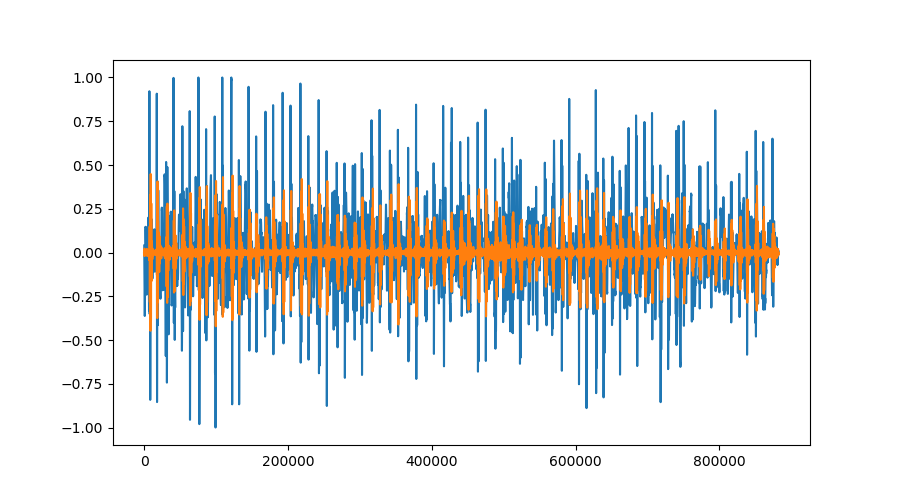

In [11]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(audio)
plt.plot(audio_bp)
plt.show()

<IPython.core.display.Javascript object>


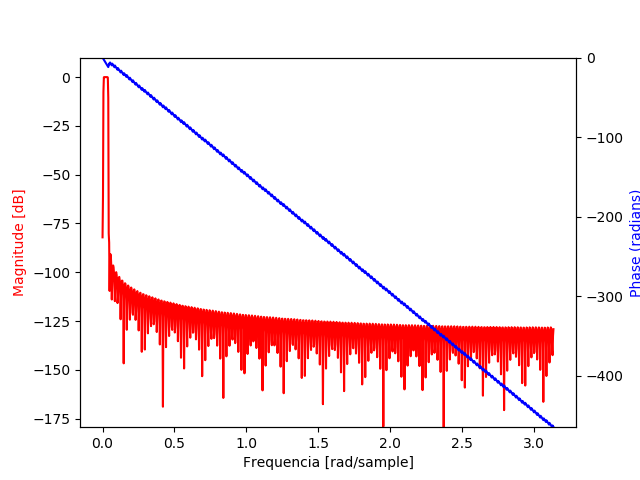

In [61]:
%matplotlib notebook
audio_bandpassed = bandpass_filter(audio, samplerate, freq_stop_1=20, freq_pass_1=70, 
                                    freq_pass_2=250, freq_stop_2=300, bp_method='sequence', 
                                    lp_method='fir', hp_method='fir', 
                                    lp_process='manual_time_design',
                                    fir_method='kaiser', gpass=1, gstop=80, 
                                    plot_filter=True, correct_by_gd=True, 
                                    gd_padding='periodic', normalize=False)

<IPython.core.display.Javascript object>


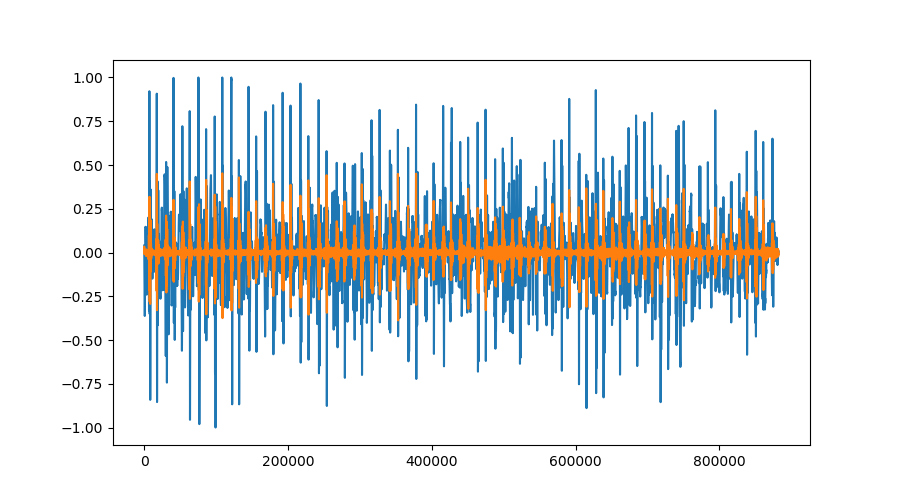

In [35]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(audio)
plt.plot(audio_bandpassed)
plt.show()

<IPython.core.display.Javascript object>


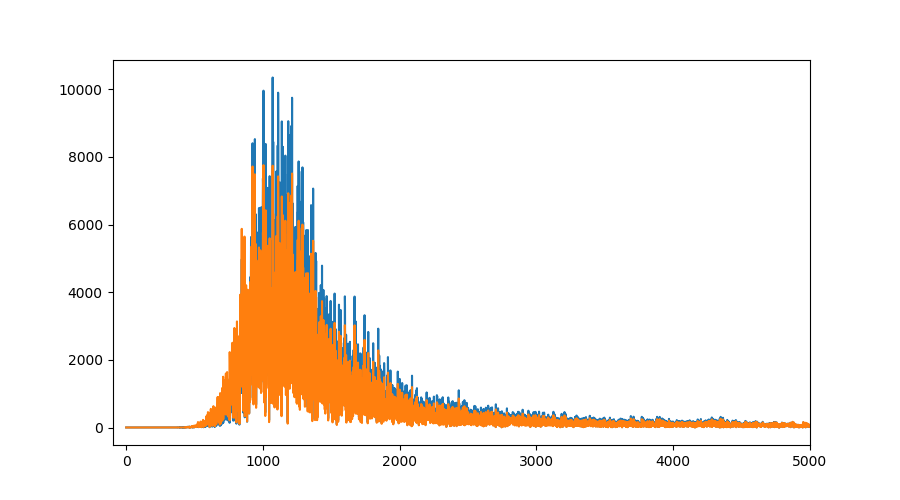

In [62]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.plot(abs(np.fft.fft(audio_bp / max(abs(audio_bp)))))
plt.plot(abs(np.fft.fft(audio_bandpassed / max(abs(audio_bandpassed)))))
plt.xlim([-100, 5000])
plt.show()

In [50]:
400 * len(audio) / samplerate

8000.0

<IPython.core.display.Javascript object>


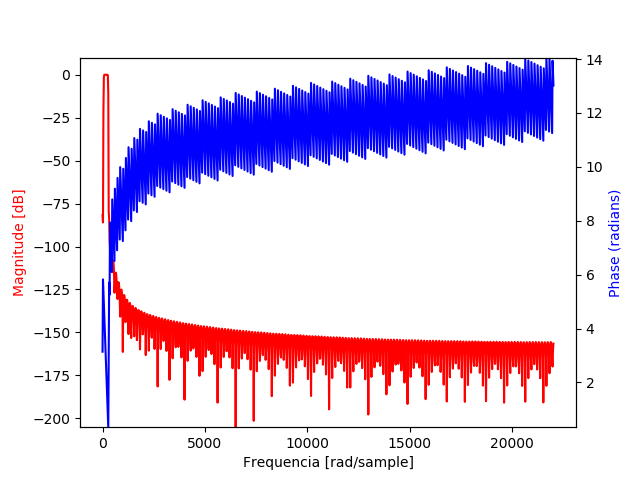

2.2540242671966553


<IPython.core.display.Javascript object>


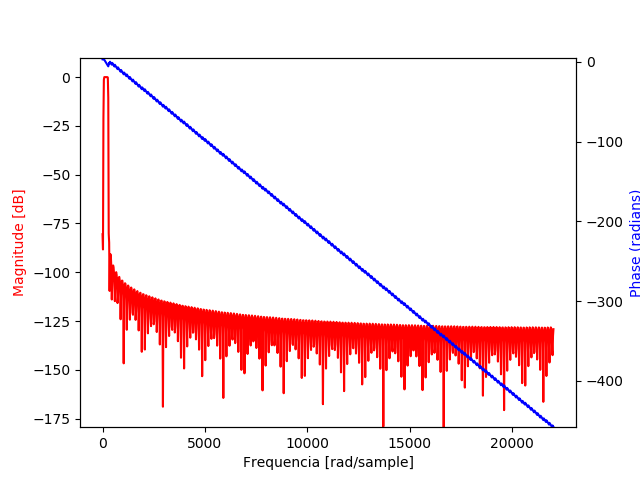

4.368269205093384


In [63]:
%matplotlib notebook
inicio = time.time()
signal_bp_1 = bandpass_filter(audio, samplerate, freq_stop_1=30, freq_pass_1=80, 
                    freq_pass_2=250, freq_stop_2=300,
                    bp_method='scipy_fir', lp_method='fir',
                    lp_process='manual_time_design',
                    hp_method='fir', fir_method='kaiser', 
                    gpass=1, gstop=80, plot_filter=True, 
                    correct_by_gd=True, gd_padding='periodic', 
                    normalize=False)
fin = time.time()

print(fin - inicio)

inicio = time.time()
signal_bp_2 = bandpass_filter(audio, samplerate, freq_stop_1=30, freq_pass_1=80, 
                    freq_pass_2=250, freq_stop_2=300,
                    bp_method='sequence', lp_method='fir',
                    lp_process='manual_time_design',
                    hp_method='fir', fir_method='kaiser', 
                    gpass=1, gstop=80, plot_filter=True, 
                    correct_by_gd=True, gd_padding='periodic', 
                    normalize=False)
fin = time.time()
print(fin - inicio)

<IPython.core.display.Javascript object>


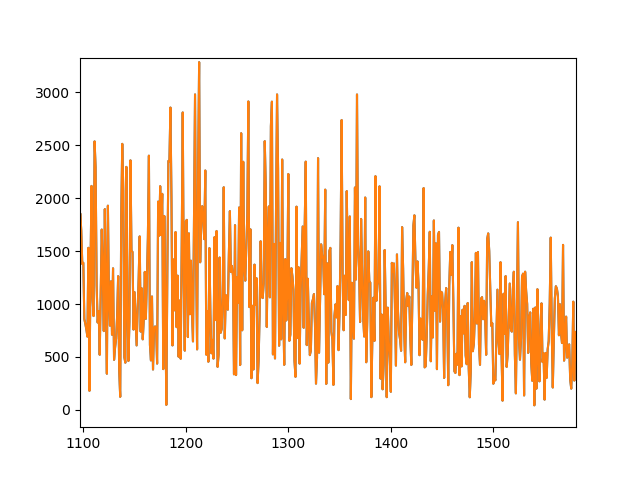

In [64]:
%matplotlib notebook


#plt.plot(abs(np.fft.fft(audio)))


plt.plot(abs(np.fft.fft(signal_bp_2)))
plt.plot(abs(np.fft.fft(signal_bp_1)))
plt.xlim([0,4000])
plt.show()

<IPython.core.display.Javascript object>


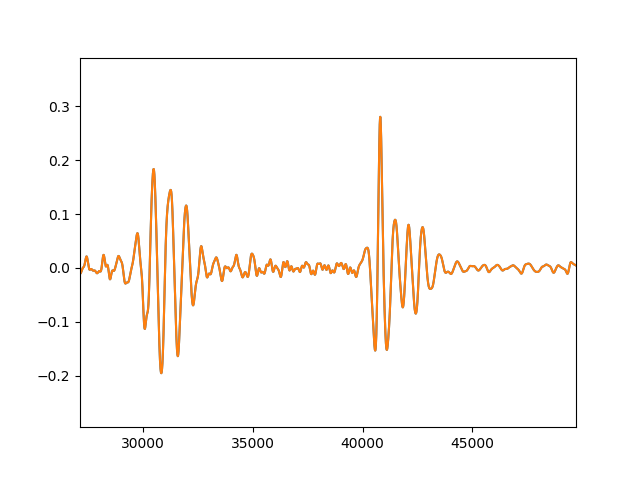

In [65]:
%matplotlib notebook
plt.plot(signal_bp_1)
plt.plot(signal_bp_2)
#plt.xlim([0,10000])
plt.show()

In [10]:
70 * len(audio) / samplerate

1400.0